<a href="https://colab.research.google.com/github/cicerohen/hands-on-ml-book/blob/main/hands_on_chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [7]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt

Initialize data

In [8]:
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist["data"], mnist["target"]

Plot a character

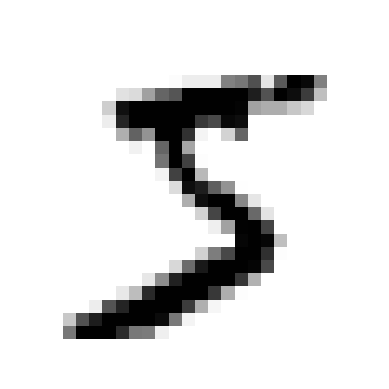

In [9]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

**SGD classifier**

In [6]:
y = y.astype(np.uint8)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

print(y_train_5)

[ True False False ...  True False False]


Make a prediction

In [10]:
y_train_pred = sgd_clf.predict(X_train)
mse = mean_squared_error(y_train_5.astype(int), y_train_pred.astype(int))
rmse = np.sqrt(mse)
print("RMSE", rmse)

RMSE 0.21847959477565254


**Cross-validation**

RMSE

In [11]:
scores = cross_val_score(sgd_clf, X_train, y_train_5.astype(int), cv=3, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)
print("RMSE", rmse_scores.mean())

RMSE 0.20698112149676487


Accuracy

*Accuracy works perfectly when your data is split 50/50. However, in your notebook, only 10% of the images are "5s" and 90% are "Not-5s."*






In [12]:
accuracy_scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print("Accuracy for each fold:", accuracy_scores)
print("Mean accuracy:", accuracy_scores.mean())

Accuracy for each fold: [0.95035 0.96035 0.9604 ]
Mean accuracy: 0.9570333333333334


**Confusion Matrix**

In [13]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
conf_matrix = confusion_matrix(y_train_5, y_train_pred)

Confusion matrix table

In [14]:
conf_matrix_df = pd.DataFrame(conf_matrix,index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
html_table = conf_matrix_df.to_html(classes='table table-bordered')
HTML(html_table)

,Predicted Negative,Predicted Positive
Actual Negative,53892,687
Actual Positive,1891,3530


Confusion matrix scores

In [15]:
prec_score = precision_score(y_train_5, y_train_pred)
rec_score = recall_score(y_train_5, y_train_pred)
f_score = f1_score(y_train_5, y_train_pred)

print("Precision: ", prec_score)
print("Recall: ", rec_score)
print("F1 Score: ", f_score)

Precision:  0.8370879772350012
Recall:  0.6511713705958311
F1 Score:  0.7325171197343847


In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

(0.0, 1.0)

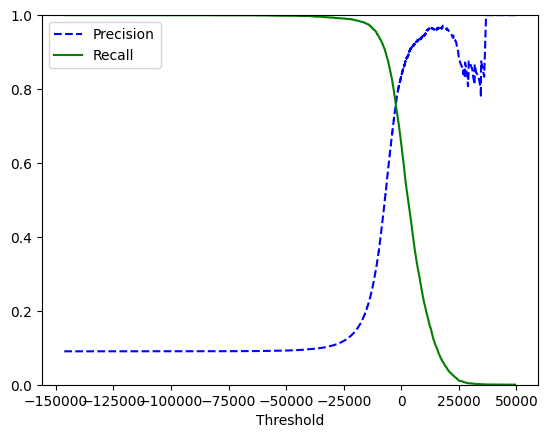

In [17]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])

Seeing precision/recall tradeoff in practice

In [18]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.50)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

print("Precision", precision_score(y_train_5, y_train_pred_90))
print("Recall/Sensitivity", recall_score(y_train_5, y_train_pred_90))

Precision 0.5
Recall/Sensitivity 0.9070282235749861


**ROC AUC Curve**

In [19]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

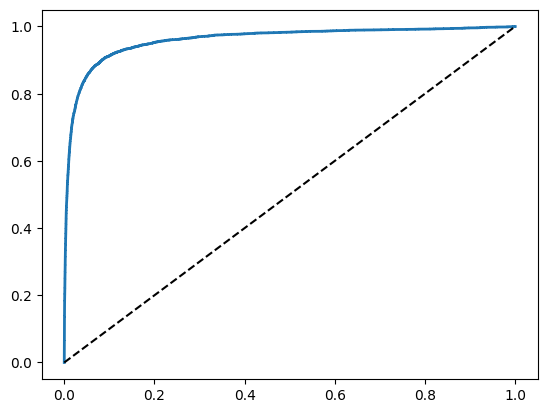

In [20]:
plt.plot(fpr, tpr, linewidth=2, label=None)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

**Random Forest Classifier**

In [21]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")


In [22]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

SGD curve vs RF curve

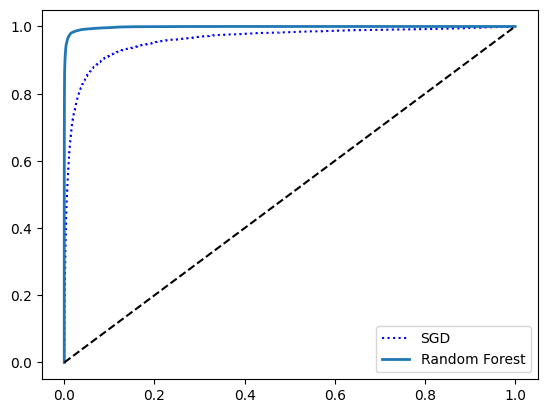

In [23]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.show()

In [24]:
print("SGD AUC scores",roc_auc_score(y_train_5, y_scores))
print("Random Forest AUC scores",roc_auc_score(y_train_5, y_scores_forest))

SGD AUC scores 0.9604938554008616
Random Forest AUC scores 0.9983436731328145


**Support Vector Machine**

In [25]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
print(svm_clf.predict([some_digit]))

[5]


In [26]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [27]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [35]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)